# GPs: the SPDE approach

This approach is based on a few fundamental results:
1. Applying a linear operator to a Gaussian random vector/field results in another Gaussian random vector/field.
2. Using FEM to solve an SPDE specified by an operator and forced by a Gaussian white noise results in sparse linear algebra operations.

Combining these two results, and providing theoretical guarantee, Lindgren et al. (2011) showed that Gaussian Markov Random Fields that arise during the construction of an FEM solution to a specific SPDE represent Gaussian Random Fields with Matern covariance kernel.



The paper has caused a paradigm shift in spatical statistics and spawned many research works. The following references below are the ones I found the most useful. This notebook is concerned mostly with the practical aspects, can be thought of as 'a Python (+FEniCS) implementation of the Lindgren et al. (2011) paper.



## Resources

1. The original paper: https://rss.onlinelibrary.wiley.com/doi/10.1111/j.1467-9868.2011.00777.x (free access)
1. Explanation of solving an SPDE: https://arxiv.org/pdf/1803.03765.pdf (arXiv)
1. A 'reflection' paper on the method: https://arxiv.org/abs/2111.01084 (arXiv)



## What this tutorial will cover:

1. Sampling based on the precision matrix without constraints.
1. Sampling by solving the PDE without constraints (Neumann boundary)
1. Sampling based on the precision matrix with constraints.
1. Sampling by solving the PDE with constraints (Dirichlet boundary)


Construction of matrices that are necessary will be done using FEniCS. Although these matrices can be easily constructed by hand in 1D, using FEniCS will make this code applicable in higher dimensions.

**Note: for the sake of quick implementation, all linear algebra operations are using dense matrices here. Note that, all required operations can be done in a sparse manner.** 

In [793]:
import ufl
from mpi4py import MPI
from dolfinx import mesh

from dolfinx.fem import FunctionSpace
from dolfinx import fem

from petsc4py.PETSc import ScalarType

import numpy as np
import matplotlib.pyplot as plt

In [869]:
num_x = 999

bc_L = 0
bc_R = 5

kappa_sq = 20
tau = 0.1

In [870]:
num_samples = 1000

In [871]:
domain = mesh.create_unit_interval(MPI.COMM_WORLD, nx=num_x)

V = FunctionSpace(domain, ("CG", 1))

u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)

## BC code for FEniCS
# def left_boundary(x):
#     return np.isclose(x[0], 0)

# def right_boundary(x):
#     return np.isclose(x[0], 1)

# left_boundary_dofs = fem.locate_dofs_geometrical(V, left_boundary)
# right_boundary_dofs = fem.locate_dofs_geometrical(V, right_boundary)

# bc_left = fem.dirichletbc(ScalarType(bc_L), left_boundary_dofs, V)
# bc_right = fem.dirichletbc(ScalarType(bc_R), right_boundary_dofs, V)

In [872]:
g = ufl.dot(ufl.grad(u), ufl.grad(v)) * ufl.dx
G_mat = fem.assemble_matrix(fem.form(g))
G = G_mat.to_dense()

c = ufl.dot(u, v) * ufl.dx
C_mat = fem.assemble_matrix(fem.form(c))
C_mat_approx = fem.assemble_vector(fem.form(ufl.inner(1.0, v)*ufl.dx))
C_full = C_mat.to_dense()

C = np.diag(C_mat_approx.array)
# C = C_full

C_inv = np.linalg.inv(C)

def get_K(kappa_sq, G, C):
    return kappa_sq * C + G

K = get_K(kappa_sq, G, C)

# Without constraints

## Sampling using Precision Matrix

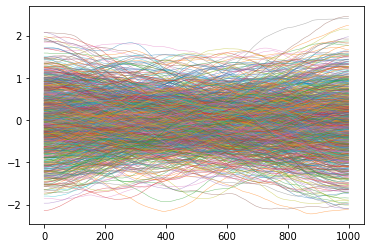

In [873]:
Q_a2 = (tau ** 2) * np.dot(K, np.dot(C_inv, K))

cov_a2 = np.linalg.inv(Q_a2)
cov_a2_chol = np.linalg.cholesky(cov_a2)

all_samples_pm_no_constraints = np.zeros((num_samples, num_x + 1))


fig, ax = plt.subplots()  #create figure and axes
for i in range(num_samples):
    all_samples_pm_no_constraints[i, :] = np.dot(cov_a2_chol, np.random.normal(loc=0.0, scale=1.0, size=cov_a2_chol.shape[0]))
    ax.plot(all_samples_pm_no_constraints[i, :], alpha=0.6, linewidth=0.5)
plt.show() 

## Sampling by solving the PDE for a sample of discretised white noise

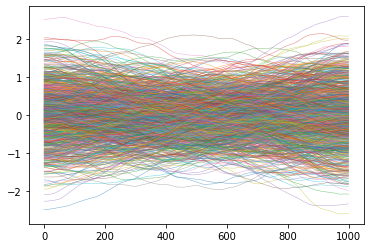

In [874]:
all_samples_spde_no_const = np.zeros((num_samples, num_x + 1))
                       
#RHS -- sample the RHS
rhs_cov_mat = fem.assemble_matrix(fem.form(ufl.dot(u, v) * ufl.dx)).to_dense()
rhs_cov_mat_chol = np.linalg.cholesky(rhs_cov_mat)

fig, ax = plt.subplots()  #create figure and axes
for i in range(num_samples):
    rhs_sample = np.dot(rhs_cov_mat_chol, np.random.normal(loc=0., scale=1., size=rhs_cov_mat_chol.shape[0]))
    rhs_sample = (1 / tau) * rhs_sample
    all_samples_spde_no_const[i, :]  = np.linalg.solve(K, rhs_sample)
    ax.plot(all_samples_spde_no_const[i, :], alpha=0.6, linewidth=0.5)

# With constraints

## Sampling using Precision Matrix

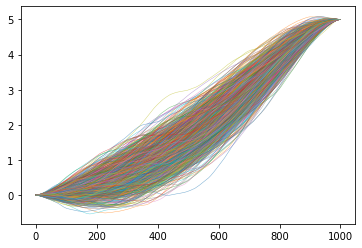

In [877]:
Q_a2 = (tau ** 2) * np.dot(K, np.dot(C_inv, K))

condition_ordering = np.arange(0, Q_a2.shape[0], 1)
condition_ordering = np.roll(condition_ordering, 1)
condition_ordering[1] = condition_ordering[0]
condition_ordering[0] = 0


Q_a2_reordered = Q_a2[condition_ordering, :][:, condition_ordering]
Q_ab = Q_a2_reordered[2:, :2]
Q_aa = Q_a2_reordered[2:, 2:]

mu_cond = np.linalg.solve(Q_aa, - np.dot(Q_ab, np.asarray([bc_L, bc_R])))
cov_cond = np.linalg.inv(Q_aa)

num_samples = 1000
all_samples_prec = np.zeros((num_samples, num_x + 1))

all_samples_prec[:, -1] = bc_R

cov_cond_chol = np.linalg.cholesky(cov_cond)

for i in range(num_samples):
    
    sample = mu_cond + np.dot(cov_cond_chol, np.random.normal(loc=0.0, scale=1.0, size=cov_cond_chol.shape[0]))
    all_samples_prec[i, 1:-1] = sample


fig, ax = plt.subplots()  #create figure and axes
for i in range(num_samples):
    ax.plot(all_samples_prec[i, :], alpha=0.6, linewidth=0.5)
plt.show()    

## Sampling by solving the PDE for a sample of discretised white noise

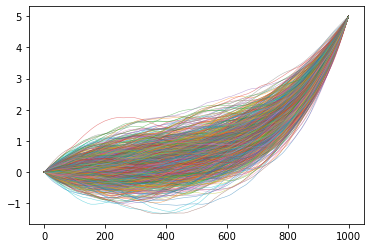

In [879]:
num_samples = 1000

all_samples = np.zeros((num_samples, num_x + 1))
                       
#RHS -- sample the RHS

rhs_cov_mat = fem.assemble_matrix(fem.form(ufl.dot(u, v) * ufl.dx)).to_dense()
rhs_cov_mat_chol = np.linalg.cholesky(rhs_cov_mat)

for i in range(num_samples):
    rhs_sample = np.dot(rhs_cov_mat_chol, np.random.normal(loc=0., scale=1., size=rhs_cov_mat_chol.shape[0]))
    
    rhs_sample = (1 / tau) * rhs_sample
    
    # Impose boundary conditions
    rhs_sample = rhs_sample - bc_L * K[:, 0]
    rhs_sample = rhs_sample - bc_R * K[:, num_x]
    
    
    rhs_sample[0] = bc_L
    rhs_sample[num_x] = bc_R
    
    K_bc = K.copy()
    K_bc[0, :] = 0
    K_bc[:, 0] = 0
    K_bc[num_x, :] = 0
    K_bc[:, num_x] = 0
    
    K_bc[0, 0] = 1.
    K_bc[num_x, num_x] = 1.
    
    all_samples[i, :]  = np.linalg.solve(K_bc, rhs_sample)
    
fig, ax = plt.subplots()  #create figure and axes
for i in range(num_samples):
    ax.plot(all_samples[i, :], alpha=0.6, linewidth=0.5)